# **Iris 꽃 분류**
* Fully Connected Layer (Dense)를 활용한 분류 모델 (Classification)
* tensorflow-datasets 를 활용한 데이터 전처리

# **문제**
For this task you will train a classifier for Iris flowers using the Iris dataset

The final layer in your neural network should look like: tf.keras.layers.

Dense(3, activation=tf.nn.softmax)

The input layer will expect data in the shape (4,)

We've given you some starter code for preprocessing the data

You'll need to implement the preprocess function for data.map

# 1. Import

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# 2. Load Dataset 및 데이터 전처리
* [Tensorflow dataset 정보 링크](https://www.tensorflow.org/datasets/catalog/iris?hl=ko)


`train_dataset`와 `valid_dataset`을 만들고 **80% : 20%로 분할**합니다.

In [5]:
train_dataset = tfds.load('iris', split='train[:80%]')
valid_dataset = tfds.load('iris', split='train[80%:]')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/iris/2.0.0.incomplete6OBUO7/iris-train.tfrecord


  0%|          | 0/150 [00:00<?, ? examples/s]

Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.


시험에서는 다음과 같은 **전처리 요구 조건**이 있습니다.

1. label 값을 **one-hot encoding** 할 것
2. feature (x), label (y)를 분할할 것

In [2]:
def preprocess(data):
  x = data['features']
  y = data['label']
  y = tf.one_hot(y, 3)
  return x, y

**batch**

1개의 Epoch에서 **여러 개의 샘플을 나누어 학습하는 단위** 

**예시**

**1,000개의 이미지**를 학습하는 경우.

* **batch_size=10** => (1000개 이미지) / (batch_size=10) = 총 **100개의 batch**
* **batch_size=20** => (1000개 이미지) / (batch_size=20) = 총 **50개의 batch**
* **batch_size=50** => (1000개 이미지) / (batch_size=50) = 총 **20개의 batch**

In [6]:
batch_size = 10
# train_data로 train_dataset과는 다른 이름으로 변수 지정
train_data = train_dataset.map(preprocess).batch(batch_size)
valid_data = valid_dataset.map(preprocess).batch(batch_size)

# 3. 모델 정의 (Sequential)

`Sequential` 모델 안에서 층을 깊게 쌓아 올려 주면 됩니다.

1. `input_shape`는 Iris 꽃 데이터셋의 X의 feature 갯수가 4개 이므로 **(4, )**로 지정합니다.
2. 깊은 출력층과 더 많은 Layer를 쌓습니다.
3. Dense Layer에 `activation='relu'`를 적용합니다.
4. 분류(Classification)의 마지막 층의 출력 숫자는 분류하고자 하는 클래스 갯수와 **같아야** 합니다.


In [8]:
model = Sequential([
                    # input_shape = (4, ) : X의 feature 개수 4개이므로
                    Dense(512, activation='relu', input_shape=(4,)),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    # Classification을 위한 softmax
                    Dense(3, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 177,219
Trainable params: 177,219
Non-trainable params: 0
__________________________________________________

# 4. Compile

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`설정
  * 출력층 activation이 `sigmoid` 인 경우: `binary_crossentropy`
  * 출력층 activation이 `softmax` 인 경우: 
    * 원핫인코딩(O): `categorical_crossentropy`
    * 원핫인코딩(X): `sparse_categorical_crossentropy`)
3. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [12]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 6. 학습

1. `validation_data`를 반드시 지정합니다.
2. `epochs`을 적절하게 지정합니다.
3. `callbacks`에 바로 위에서 만든 checkpoint를 지정합니다.

In [13]:
history = model.fit(train_data,
                    validation_data= (valid_data),
                    epochs=20,
                    callbacks=[checkpoint])

Epoch 1/20
12/12 [==============================] - 1s 20ms/step - loss: 0.8325 - acc: 0.6667 - val_loss: 0.5496 - val_acc: 0.8667

Epoch 00001: val_loss improved from inf to 0.54955, saving model to my_checkpoint.ckpt
Epoch 2/20
12/12 [==============================] - 0s 8ms/step - loss: 0.3918 - acc: 0.8750 - val_loss: 0.3251 - val_acc: 0.8667

Epoch 00002: val_loss improved from 0.54955 to 0.32507, saving model to my_checkpoint.ckpt
Epoch 3/20
12/12 [==============================] - 0s 8ms/step - loss: 0.2082 - acc: 0.9417 - val_loss: 0.2484 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.32507 to 0.24844, saving model to my_checkpoint.ckpt
Epoch 4/20
12/12 [==============================] - 0s 8ms/step - loss: 0.1702 - acc: 0.9167 - val_loss: 0.3257 - val_acc: 0.8667

Epoch 00004: val_loss did not improve from 0.24844
Epoch 5/20
12/12 [==============================] - 0s 9ms/step - loss: 0.0894 - acc: 0.9750 - val_loss: 0.1573 - val_acc: 0.9333

Epoch 00005: val_loss im

# 7. 학습 완료 후 Load Weights

In [14]:
model.load_weights(checkpoint_path)

# 학습 Loss에 대한 시각화

In [15]:
import matplotlib.pyplot as plt


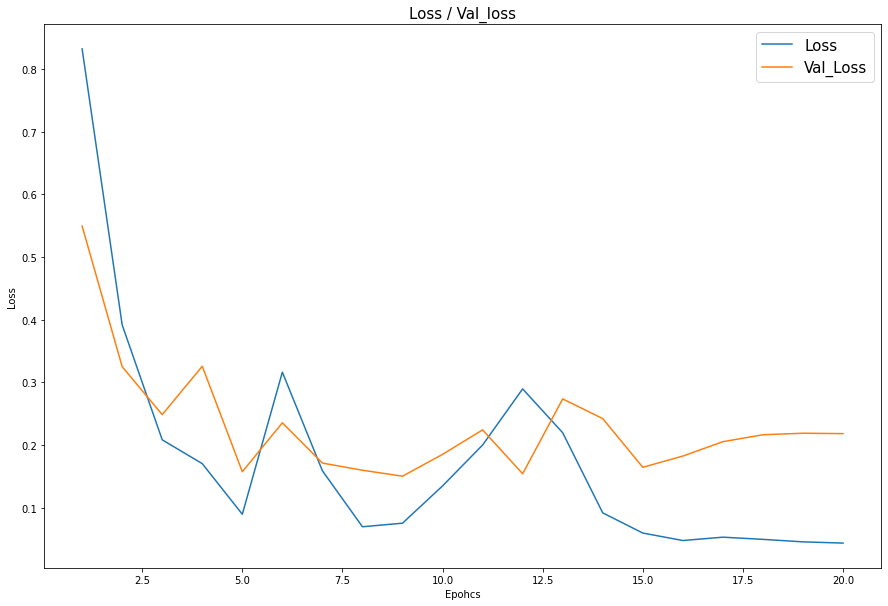

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(1, 21), history.history['loss'])
plt.plot(np.arange(1, 21), history.history['val_loss'])
plt.title('Loss / Val_loss', fontsize=15)
plt.xlabel('Epohcs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Val_Loss'], fontsize=15)
plt.show()

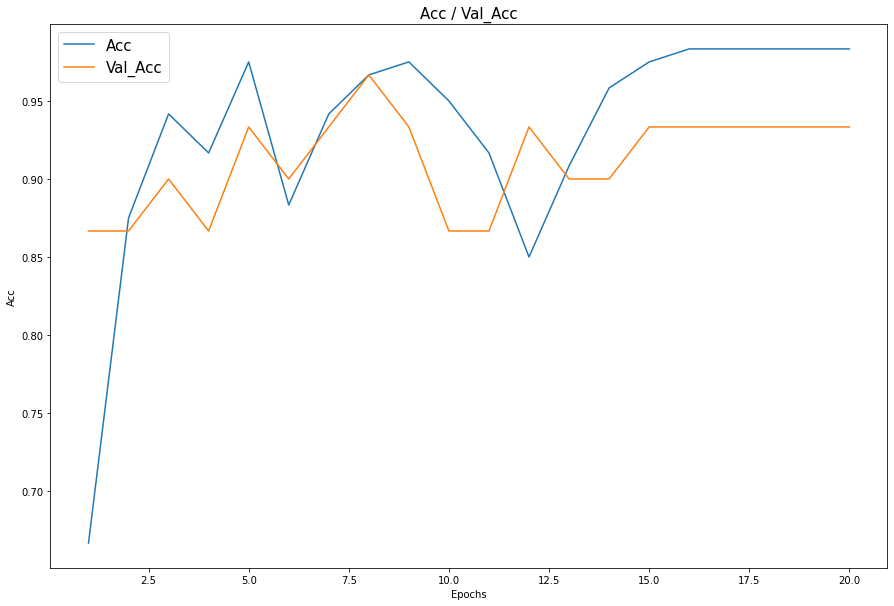

In [18]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1, 21), history.history['acc'])
plt.plot(np.arange(1, 21), history.history['val_acc'])
plt.title('Acc / Val_Acc', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Acc', 'Val_Acc'], fontsize=15)
plt.show()

# Review

For this task you will train a classifier for Iris flowers using the Iris dataset

The final layer in your neural network should look like: tf.keras.layers.

Dense(3, activation=tf.nn.softmax)

The input layer will expect data in the shape (4,)

We've given you some starter code for preprocessing the data

You'll need to implement the preprocess function for data.map

In [2]:
# import
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
# Load dataset & preprocessing
train_dataset = tfds.load('iris', split='train[:80%]')
valid_dataset = tfds.load('iris', split='train[80%:]')

In [9]:
def preprocess(data):
  x = data['features']
  y = data['label']
  y = tf.one_hot(y, 3)
  return x, y

In [10]:
batch_size = 10

train_data = train_dataset.map(preprocess).batch(batch_size)
valid_data = valid_dataset.map(preprocess).batch(batch_size)

In [12]:
# model 정의 (Sequential)
model = Sequential([
                    Dense(512, activation='relu', input_shape=(4, )),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(32, activation='relu'),
                    # classfication
                    Dense(3, activation='softmax')
])

In [13]:
# compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [14]:
# ModelCheckpoint
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only = True,
                             save_best_only = True,
                             monitor='val_loss',
                             verbose = 1)

In [16]:
# fit
model.fit(train_data,
          validation_data = (valid_data),
          epochs= 20,
          callbacks=[checkpoint])

Epoch 1/20
12/12 [==============================] - 3s 25ms/step - loss: 0.8686 - acc: 0.5833 - val_loss: 0.5947 - val_acc: 0.8667

Epoch 00001: val_loss improved from inf to 0.59467, saving model to my_checkpoint.ckpt
Epoch 2/20
12/12 [==============================] - 0s 10ms/step - loss: 0.4617 - acc: 0.8333 - val_loss: 0.4115 - val_acc: 0.8333

Epoch 00002: val_loss improved from 0.59467 to 0.41148, saving model to my_checkpoint.ckpt
Epoch 3/20
12/12 [==============================] - 0s 10ms/step - loss: 0.3081 - acc: 0.9083 - val_loss: 0.2735 - val_acc: 0.9333

Epoch 00003: val_loss improved from 0.41148 to 0.27346, saving model to my_checkpoint.ckpt
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 0.2616 - acc: 0.8833 - val_loss: 0.3127 - val_acc: 0.8667

Epoch 00004: val_loss did not improve from 0.27346
Epoch 5/20
12/12 [==============================] - 0s 11ms/step - loss: 0.1549 - acc: 0.9333 - val_loss: 0.1834 - val_acc: 0.9667

Epoch 00005: val_los

In [17]:
# load weights
model.load_weights(checkpoint_path)